# 1. Imports

## 1.1 Librairies

In [27]:
import time
import os
from os import listdir
from glob import glob

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import preprocessing, manifold, decomposition
from sklearn import cluster, metrics

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

import cv2

### 1.1.1 Options

In [28]:
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

sns.set()

## 1.2 Data

In [29]:
data = pd.read_csv('data/df_images.csv', sep=";")
data.head(1)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  image  category_level_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing    

           category_level_2 category_level_3  \
0   Curtains & Accessories         Curtains    

                                    category_level_4 category_level_5  \
0   Elegance Polyester Multicolor Abstract Eyelet...     Non spécifié   

  category_level_6 category_level_7  \
0     Non spécifié     Non spécifié   

                                       filtered_text  
0  elegance polyester multicolor abstract eyelet ...

In [30]:
exemples_images_folder = "data/images_exemple"

## 2. Prétraitement des images

In [31]:
image_files = [os.path.join(exemples_images_folder, file) for file in os.listdir(exemples_images_folder) if file.endswith('.jpg')]

### 2.1 Contraste

In [32]:
def apply_contrast(image_path, alpha=1.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    contrasted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
    return image, contrasted_image

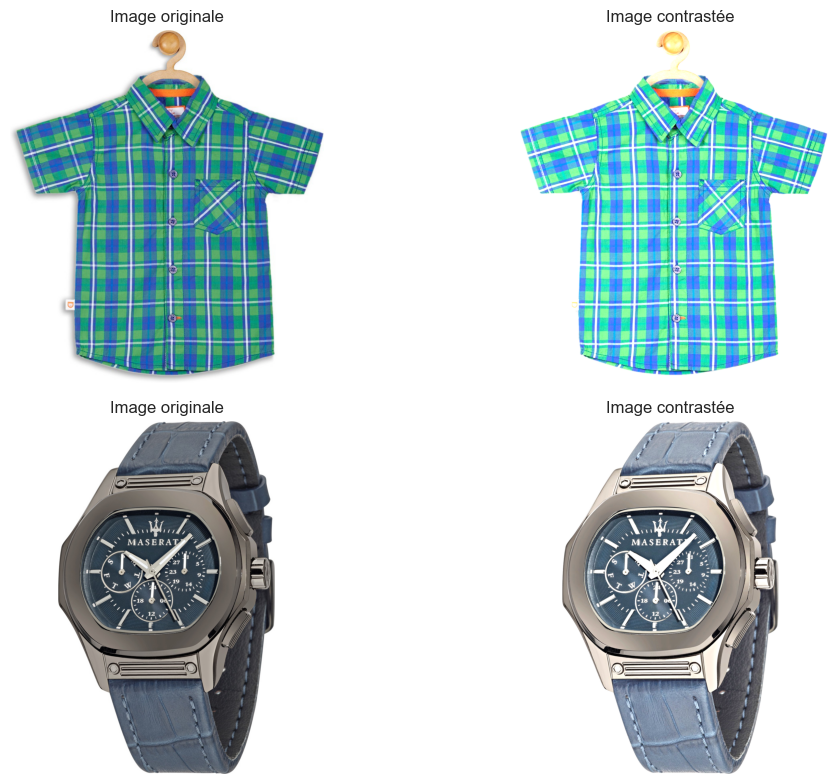

In [33]:
plt.figure(figsize=(12, 8))

for index, image_path in enumerate(image_files):
    original, contrasted = apply_contrast(image_path, alpha=1.5)

    plt.subplot(len(image_files), 2, index * 2 + 1)
    plt.imshow(original)
    plt.title('Image originale')
    plt.axis("off")

    plt.subplot(len(image_files), 2, index * 2 + 2)
    plt.imshow(contrasted)
    plt.title("Image contrastée")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2.2 Passage en gris / filtrage du bruit / égalisation / floutage

In [34]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Passage en gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Filtrage du bruit
    denoised_image = cv2.medianBlur(image, 11)

    # Egalisation de l'image
    equalized_channels = [cv2.equalizeHist(channel) for channel in cv2.split(image)]
    equalized_image = cv2.merge(equalized_channels)

    # Floutage
    blurred_image = cv2.GaussianBlur(image, (11, 11), 10)

    return image, gray_image, denoised_image, equalized_image, blurred_image

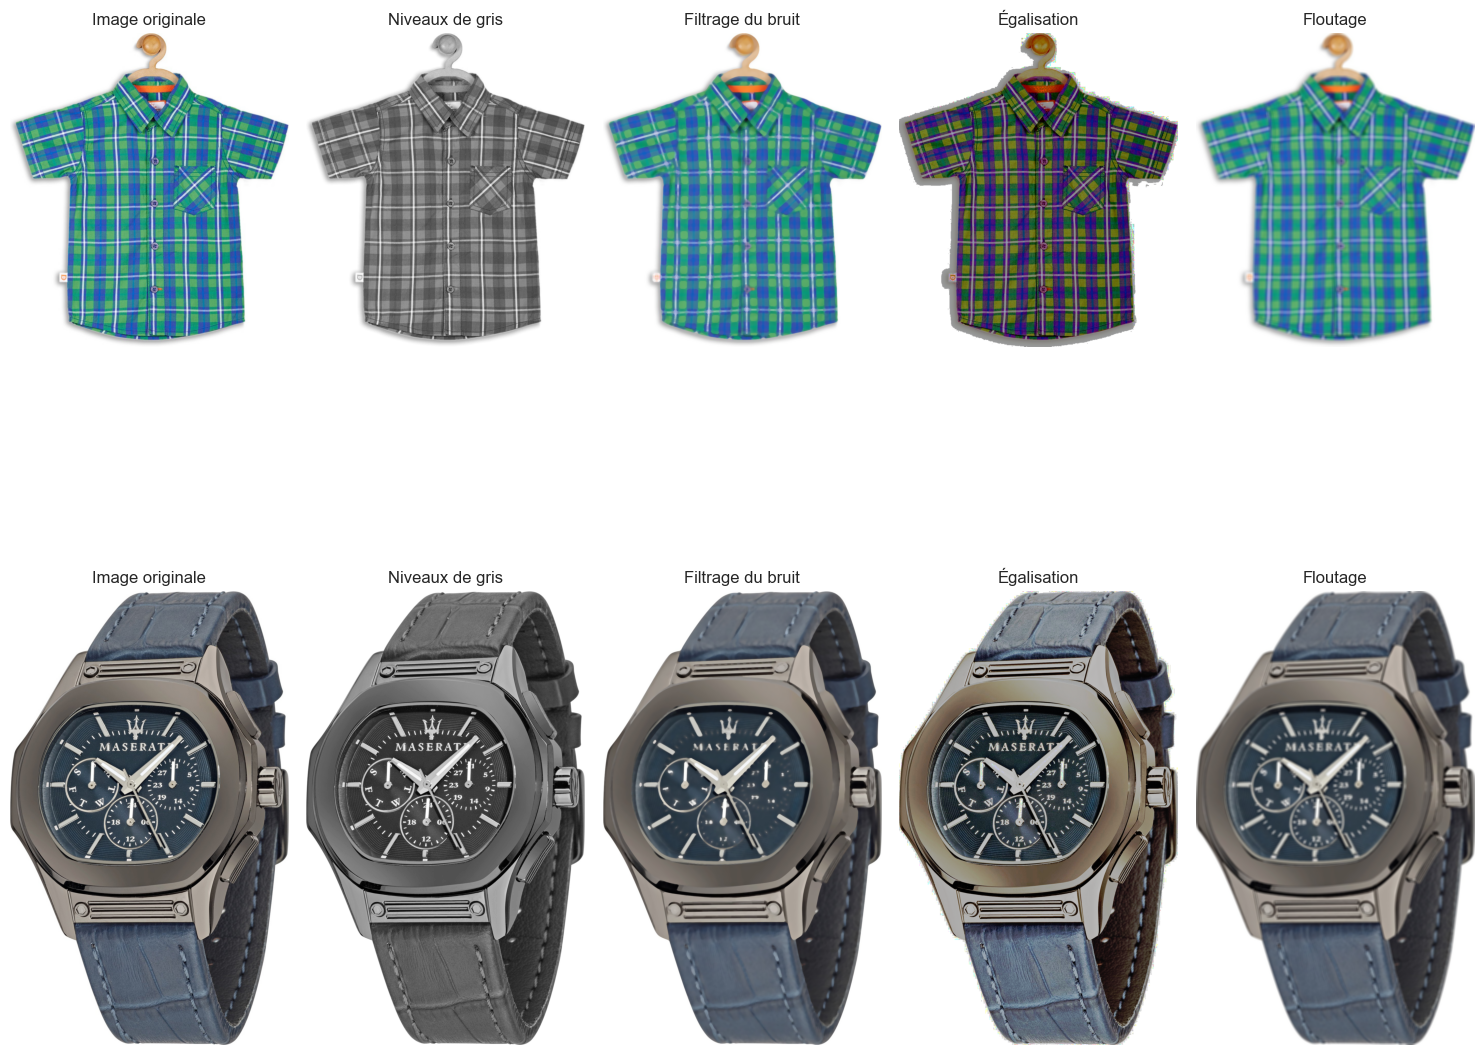

In [35]:
plt.figure(figsize=(15, 15))

for index, image_path in enumerate(image_files):
    original, gray, denoised, equalized, blurred = preprocess_image(image_path)

    plt.subplot(len(image_files), 5, index * 5 + 1)
    plt.imshow(original)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(len(image_files), 5, index * 5 + 2)
    plt.imshow(gray, cmap="gray")
    plt.title("Niveaux de gris")
    plt.axis("off")

    plt.subplot(len(image_files), 5, index * 5 + 3)
    plt.imshow(denoised)
    plt.title("Filtrage du bruit")
    plt.axis("off")

    plt.subplot(len(image_files), 5, index * 5 + 4)
    plt.imshow(equalized)
    plt.title("Égalisation")
    plt.axis("off")

    plt.subplot(len(image_files), 5, index * 5 + 5)
    plt.imshow(blurred)
    plt.title("Floutage")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2.3 Extraction de features - bag of images

In [36]:
def extract_sift_features(image_paths):
    sift = cv2.SIFT_create()
    features = {}

    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Impossible de lire limage : {image_path}")
            continue

        # Détection de points clés et calcul des descripteurs
        keypoints, descriptors = sift.detectAndCompute(image, None)

        # Stockage des descripteurs dans un dictionnaire
        features[image_path] = descriptors

        plt.figure(figsize=(5, 5))
        keypoint_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(keypoint_image, cmap='gray')
        plt.title(f"Points clés détectés pour : {os.path.basename(image_path)}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return features

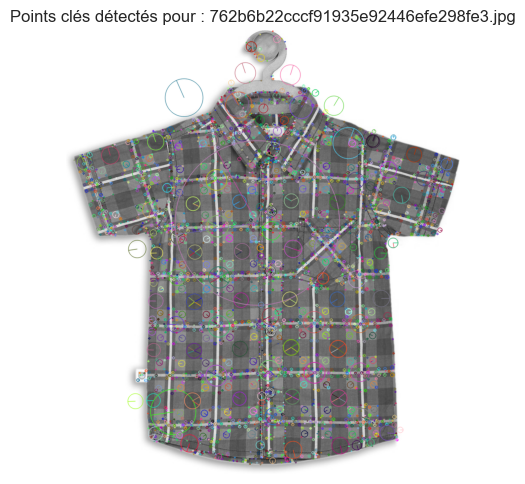

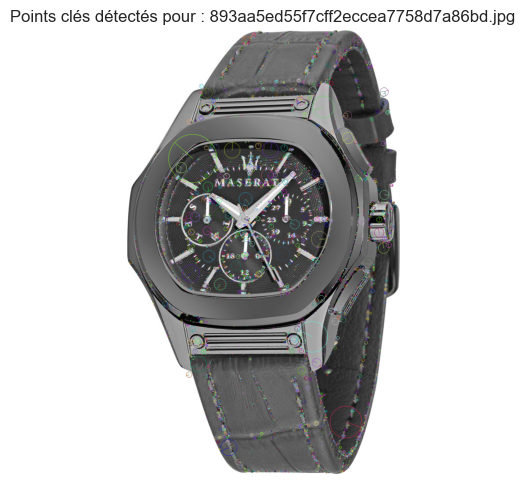

In [37]:
sift_features = extract_sift_features(image_files)

In [38]:
for image_path, descriptors in sift_features.items():
    print(len(descriptors))

4156
4488


## 2.4 VGG16

In [39]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Voici ce que le summary nous apprend, déjà du côté de l'architecture générale :

- Le modèle prend en charge une image d'entrée de taille 224x224 avec 3 canaux pour les couleurs RGB
- Il y a 5 blocks de convolution(block1_conv1, block2_conv1...) avec une étape de MaxPooling pour réduire la dimension spatiale
- Les couches denses préparent les caractéristiques pour une tâche de classification

La sortie se fait sur la dernière couche dense (output layers -2) avec une taille de 4096 dimensions. Cette couche peut être utilisée pour de l'apprentissage ou clustering. Tous les paramètres sont entraînables (134,260,544)

### 2.4.1 Extraction des features des images

In [40]:
def extract_vgg16_features(folder_path, model, batch_size=50):
    Image.MAX_IMAGE_PIXELS = None
    image_paths = glob(os.path.join(folder_path, "*.jpg"))
    image_names = []
    image_features = []

    for i, image_file in enumerate(image_paths):
        if i % batch_size == 0:
            print(f"{i} image traitées")

        try:
            # Récupération du nom de l'image
            image_name = os.path.basename(image_file)
            image_names.append(image_name)
            
            # Chargement et prétraitement de l'image
            image = load_img(image_file, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)

            # Extraction des features avec le modèle
            features = model.predict(image, verbose=0)[0]
            image_features.append(features)

        except Exception as e:
            print(f"Erreur avec l'image {image_file} : {e}")
            image_names.pop()

    # Création du df
    features_matrix = np.vstack(image_features)
    df_features = pd.DataFrame(
        features_matrix,
        columns=[f'feature_{i}' for i in range(features_matrix.shape[1])]
    )
    df_features.insert(0, "image_name", image_names)

    print(f"Extraction terminée. Nombre d'images traitées : {len(image_features)}")
    return df_features

In [41]:
folder_path = "data/images"

df_features = extract_vgg16_features(folder_path, model)
df_features.head()

0 image traitées


C:\Dev\Logiciels\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


50 image traitées
100 image traitées
150 image traitées
200 image traitées
250 image traitées
300 image traitées
350 image traitées
400 image traitées
450 image traitées
500 image traitées
550 image traitées
600 image traitées
650 image traitées
700 image traitées
750 image traitées
800 image traitées
850 image traitées
900 image traitées
950 image traitées
1000 image traitées
Extraction terminée. Nombre d'images traitées : 1050


image_name  feature_0  feature_1  feature_2  \
0  009099b1f6e1e8f893ec29a7023153c4.jpg       2.59       2.70       0.00   
1  0096e89cc25a8b96fb9808716406fe94.jpg       0.00       0.00       0.00   
2  00cbbc837d340fa163d11e169fbdb952.jpg       0.00       0.00       0.00   
3  00d84a518e0550612fcfcba3b02b6255.jpg       0.00       0.00       0.00   
4  00e966a5049a262cfc72e6bbf68b80e7.jpg       0.00       0.00       1.53   

   feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  \
0       3.30       1.67       0.00       0.00       0.00       0.00   
1       2.22       0.00       0.00       0.00       0.00       0.00   
2       2.02       0.00       0.50       2.57       0.00       0.00   
3       0.00       0.17       0.00       0.00       1.38       0.00   
4       0.00       0.00       0.00       0.00       0.00       0.00   

   feature_9  feature_10  feature_11  feature_12  feature_13  feature_14  \
0       2.13        0.00        0.00        0.00        0.00        0.00   
1       0.00        0.00        0.00        0.00        0.00        0.00   
2       0.00        0.00        0.00        0.18        0.00        0.00   
3       1.56        0.54        0.00        0.00        0.00        0.00   
4       0.00        0.00        0.00        0.00        0.00        0.00   

   feature_15  feature_16  feature_17  feature_18  feature_19  feature_20  \
0        1.23        1.60        0.00        0.00        0.00        0.00   
1        0.00        0.00        0.00        0.00        0.00        0.00   
2        0.00        0.00        0.00        0.00        0.00        1.12   
3        0.00        0.00        2.22        0.00        0.00        0.00   
4        0.00        3.45        0.00        0.00        0.00        0.00   

   feature_21  feature_22  feature_23  feature_24  feature_25  feature_26  \
0        0.00        0.00        0.00        1.32        0.00        0.00   
1        0.89        0.00        0.00        0.04        0.00        0.00   
2        0.00        0.51        1.49        0.00        0.00        0.00   
3        3.25        0.00        0.00        0.00        2.00        9.39   
4        0.00        0.00        6.48        0.00        0.00        0.00   

   feature_27  feature_28  feature_29  feature_30  feature_31  feature_32  \
0        0.00        0.00        0.00        0.00        0.00        0.00   
1        0.00        0.00        0.00        0.00        0.00        0.00   
2        1.70        0.00        0.00        0.00        1.11        0.00   
3        0.00        0.00        1.84        0.00        0.00        0.00   
4        4.88        0.00        2.49        0.75        0.00        0.00   

   feature_33  feature_34  feature_35  feature_36  feature_37  feature_38  \
0        0.00        0.00        0.00        0.00        1.13        0.00   
1        0.00        0.00        0.00        0.00        0.46        2.67   
2        0.00        0.00        0.29        0.00        5.90        1.57   
3        0.52        0.00        0.40        0.00        4.50        1.88   
4        0.00        0.87        0.00        0.00        3.88        0.00   

   feature_39  feature_40  feature_41  feature_42  feature_43  feature_44  \
0        0.00        0.00        0.00        0.00        0.00        0.00   
1        0.00        0.26        0.00        0.35        0.00        0.00   
2        0.00        0.26        1.91        0.00        3.26        0.00   
3        4.42        0.00        3.90        0.00        2.89        0.00   
4        0.00        0.00        0.00        1.28        0.00        0.00   

   feature_45  feature_46  feature_47  feature_48  feature_49  feature_50  \
0        0.00        0.00        1.81        0.00        0.00        0.04   
1        0.00        1.65        1.41        0.00        2.23        0.00   
2        3.50        0.00        0.00        0.00        0.00        0.00   
3        0.00        0.00        0.00        0.00        0.00    

In [42]:
df_features.shape

(1050, 4097)

### 2.4.2 ACP

In [43]:
features = df_features.drop(columns=['image_name']).values
features

array([[2.5928059 , 2.698754  , 0.        , ..., 0.87792516, 0.        ,
        2.9672089 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16597968,
        2.9202015 ],
       [0.        , 0.        , 0.        , ..., 0.6985375 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.4187522 , ..., 0.        , 0.        ,
        0.0853613 ],
       [1.016454  , 1.8210591 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9676372 , 6.0002813 , 0.        , ..., 0.        , 0.        ,
        4.0833983 ]], dtype=float32)

In [44]:
print(features.shape)
pca = decomposition.PCA(n_components=99)
feat_pca = pca.fit_transform(features)
print(feat_pca.shape)

(1050, 4096)
(1050, 99)


In [45]:
time1 = time.time()

tsne = manifold.TSNE(n_components=2,
                     perplexity=60, 
                     n_iter=1000,
                     learning_rate=10,
                     init='random', 
                     random_state=42)

X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-time1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             5.27 secondes


### 2.4.3 Visualisation TSNE

In [46]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['image_name'] = df_features['image_name']

df_tsne = df_tsne.merge(data[['image', 'category_level_1']],
                       left_on='image_name', right_on='image', how='left')


df_tsne

tsne1  tsne2                            image_name  \
0     15.35 -10.58  009099b1f6e1e8f893ec29a7023153c4.jpg   
1      4.05   6.36  0096e89cc25a8b96fb9808716406fe94.jpg   
2     -9.62  -9.57  00cbbc837d340fa163d11e169fbdb952.jpg   
3     -5.89  17.54  00d84a518e0550612fcfcba3b02b6255.jpg   
4     -3.97  -1.66  00e966a5049a262cfc72e6bbf68b80e7.jpg   
...     ...    ...                                   ...   
1045   7.83  21.89  feefbdff924dd6b7cc266449c9a36d69.jpg   
1046 -17.31 -18.82  ff24511994fc459d04145231c8876d6c.jpg   
1047  13.39  22.29  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
1048 -16.55 -15.60  ffc2e1fc7c886ec09a331040ada038aa.jpg   
1049   1.88   4.52  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                                     image           category_level_1  
0     009099b1f6e1e8f893ec29a7023153c4.jpg                   Watches   
1     0096e89cc25a8b96fb9808716406fe94.jpg          Kitchen & Dining   
2     00cbbc837d340fa163d11e169fbdb952.jpg           Home Furnishing   
3     00d84a518e0550612fcfcba3b02b6255.jpg  Beauty and Personal Care   
4     00e966a5049a262cfc72e6bbf68b80e7.jpg                 Computers   
...                                    ...                        ...  
1045  feefbdff924dd6b7cc266449c9a36d69.jpg          Kitchen & Dining   
1046  ff24511994fc459d04145231c8876d6c.jpg           Home Furnishing   
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg          Kitchen & Dining   
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg           Home Furnishing   
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg                 Computers   

[1050 rows x 5 columns]

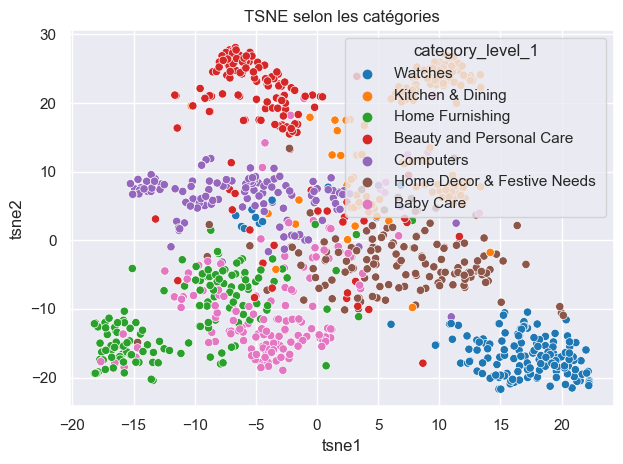

In [47]:
plt.Figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category_level_1",
    palette=sns.color_palette('tab10', n_colors=data['category_level_1'].nunique()),
    data=df_tsne, legend="brief"
)

plt.title("TSNE selon les catégories")
plt.tight_layout()
plt.show()

On peut voir clairement certaines catégories se dissocier facilement ("watches" ou encore "beauty and personal care"). Certaines catégories sont tout de même un peu mélanger dû potentiellement à leurs utilisation quotidienne ("home furnishing" et "baby care") par exemple.

### 2.4.4 KMeans

In [29]:
cls = cluster.KMeans(n_clusters=7)
cls.fit(X_tsne)

C:\Dev\Logiciels\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Dev\Logiciels\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=7)

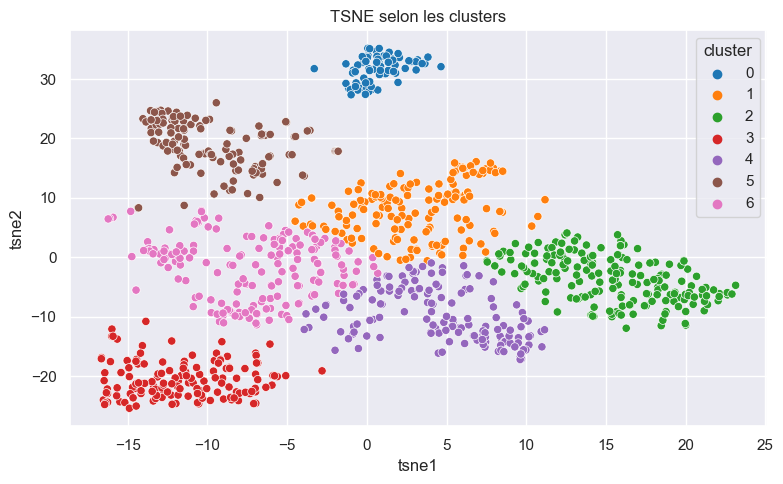

ARI :  -0.0006909547869531772


In [38]:
df_tsne['cluster']= cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7),
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')

plt.tight_layout()
plt.show()

labels = data["category_level_1"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [53]:
df_tsne_kmeans = df_tsne.set_index('image_name').loc[data['image']].reset_index()

In [54]:
df_tsne_kmeans.head(5)

image_name  tsne1  tsne2  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   5.83 -11.84   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg  10.53  -0.99   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg  14.02  -0.99   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   9.68 -11.70   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  10.17 -13.39   

                                  image  category_level_1  cluster  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing         4  
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care         2  
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care         2  
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing         4  
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing         4

C:\Dev\Logiciels\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Dev\Logiciels\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


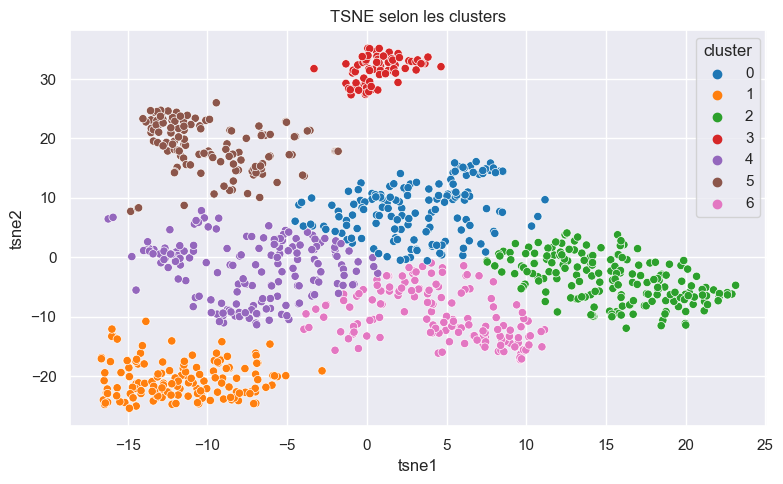

ARI :  0.487706127648779


In [62]:
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(df_tsne_kmeans[['tsne1', 'tsne2']])

df_tsne_kmeans['cluster'] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7),
    data=df_tsne_kmeans,
    legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')

plt.tight_layout()
plt.show()

labels = data["category_level_1"]
print("ARI : ", metrics.adjusted_rand_score(labels, df_tsne_kmeans['cluster']))